This noteboook contains R code to produce Figure 2 - model interpretability

In [0]:
%r
library(SparkR)

shap_df <- read.df(path="/mnt/stage-delta-lake/ds/applied_data_science/ed_insights_pub/prediction_store_v42")
shap_df <- as.data.frame(shap_df)

# split prediction_id in mrn and date columns
out <- strsplit(shap_df$prediction_id, split=":")
out <- do.call(rbind, out)
colnames(out) <- c("mrn", "date")
shap_df <- cbind(shap_df, out)

test_df <- read.df(path="/mnt/stage-delta-lake/ds/applied_data_science/ed_insights_pub/bhe_vae_knn_v42_test")
test_df <- as.data.frame(test_df)
test_df$prediction_id <- paste0(test_df$mrn, ":", test_df$date)

train_df <- read.df(path="/mnt/stage-delta-lake/ds/applied_data_science/ed_insights_pub/bhe_vae_knn_v42_train")
train_df <- as.data.frame(train_df)
train_df$prediction_id <- paste0(train_df$mrn, ":", train_df$date)

neighbor_df <- read.df(path="/mnt/stage-delta-lake/ds/applied_data_science/ed_insights_pub/bhe_vae_knn_v42_neighbors_test")
neighbor_df <- as.data.frame(neighbor_df)
neighbor_df$prediction_id <- paste0(neighbor_df$train_mrn, ":", neighbor_df$train_date)
neighbor_df$query_prediction_id <- paste0(neighbor_df$query_mrn, ":", neighbor_df$query_date)


Attaching package: ‘SparkR’

The following object is masked _by_ ‘.GlobalEnv’:

    setLocalProperty

The following objects are masked from ‘package:stats’:

    cov, filter, lag, na.omit, predict, sd, var, window

The following objects are masked from ‘package:base’:

    as.data.frame, colnames, colnames<-, drop, endsWith, intersect,
    rank, rbind, sample, startsWith, subset, summary, transform, union


In [0]:
%r
library(ggplot2)
library(tidyverse)
library(reshape2)

remotes::install_github("hrbrmstr/waffle")
library(waffle)

install.packages("cowplot")
library(cowplot)

ronin_colors <- c("#315677", "#3392c0", "#b5d5e7", "#ffab40", "#637176")

* installing *source* package ‘rlang’ ...
** package ‘rlang’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
gcc -I"/usr/share/R/include" -DNDEBUG -I./rlang/    -fvisibility=hidden -fpic  -g -O2 -fdebug-prefix-map=/build/r-base-lENDSu/r-base-4.1.3=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c capture.c -o capture.o
gcc -I"/usr/share/R/include" -DNDEBUG -I./rlang/    -fvisibility=hidden -fpic  -g -O2 -fdebug-prefix-map=/build/r-base-lENDSu/r-base-4.1.3=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c internal.c -o internal.o
g++ -std=gnu++11 -I"/usr/share/R/include" -DNDEBUG -I./rlang/     -fpic  -g -O2 -fdebug-prefix-map=/build/r-base-lENDSu/r-base-4.1.3=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c rlang-rcc.cpp -o rlang-rcc.o
gcc -I"/usr/share/R/include" -DNDEBUG -I./rlang/    -fvisibility=hidden -f

In [0]:
%r

# melt shap and test data frames, and combine
m_shap_df <- melt(shap_df, id.vars=c("mrn", "date", "prediction_id"))
m_shap_df$shap_variable <- paste0(m_shap_df$variable, "_shap")
m_shap_df$shap_value <- m_shap_df$value
m_shap_df$value <- NULL

m_test_df <- melt(test_df, id.vars=c("mrn", "date", "prediction_id", "prediction"))

merge_df <- merge(m_shap_df, m_test_df, by=c("mrn", "date", "prediction_id", "variable"))

In [0]:
%r
# We want to calculate average shap values for patients who have each feature (e.g. race = white)
# remove the 0 class of each one-hot encoded variable should build a table that can directly be 
# used calculate this

ohe_variables <- colnames(test_df)[apply(test_df, 2, function(x) { all(x %in% 0:1) })]
ohe_variables <- c(ohe_variables, "days_since_last_ed", "previous_windowed_ed_visit")

# remove 0 classes from the ohe variables
t <- merge_df[!((merge_df$variable %in% ohe_variables) & (merge_df$value == 0)),]

# remove the 0 class from previous_windowed_ed_visits and the 1 class from days_since last_ed
t <- t[!(t$variable=="previous_windowed_ed_visits" & t$value==0),]
t <- t[!(t$variable=="days_since_last_ed" & t$value==1),]

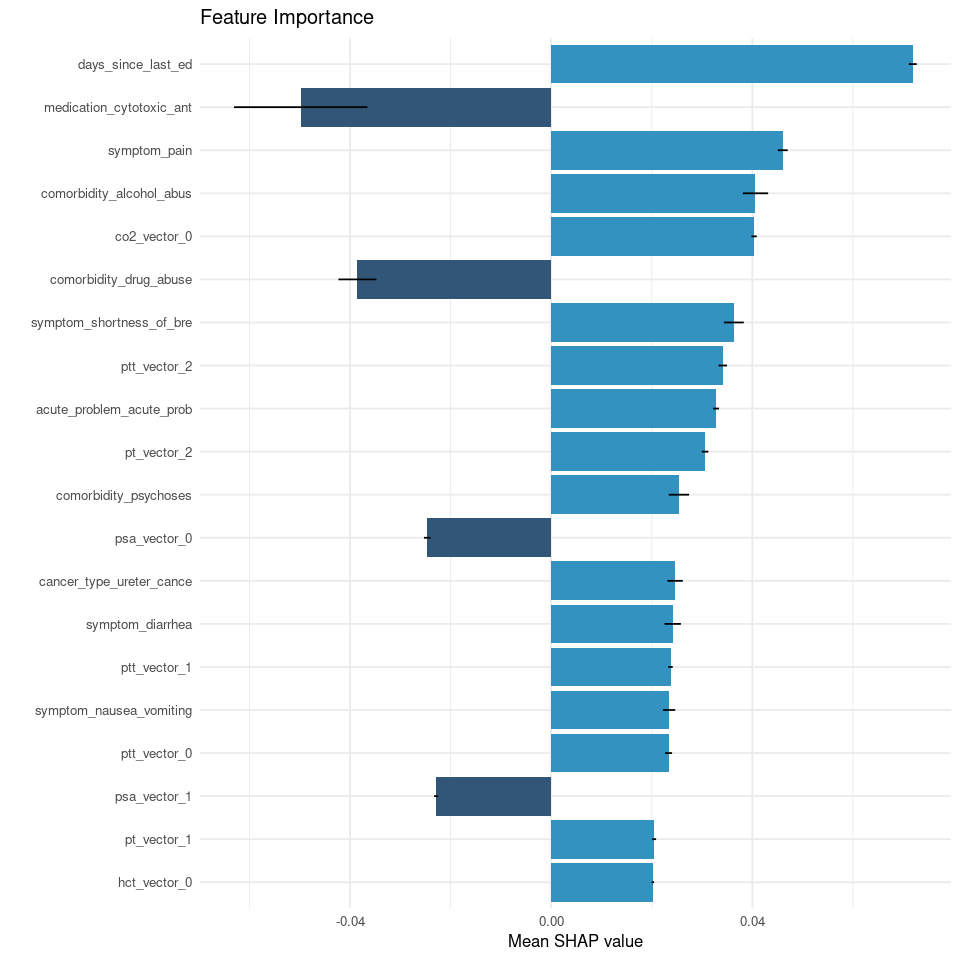

In [0]:
%r
# plot feature+value importance
mean_df <- t %>% 
  group_by(variable) %>%
  summarize(
     mean_val=mean(shap_value),
     se=sd(shap_value) / sqrt(length(shap_value)),
     min=mean_val - 1.96*se,
     max=mean_val + 1.96*se) %>%
  arrange(desc(abs(mean_val))) %>%
  mutate(variable=factor(variable, levels=variable)) %>%
  head(20)

# add a column for sign
mean_df$sign <- 0
mean_df[mean_df$mean_val > 0,]$sign <- 1

shap_p <- ggplot(mean_df, aes(y=variable, x=mean_val, fill=as.factor(sign))) + 
  geom_bar(stat="identity") +
  geom_errorbar(aes(xmin=min, xmax=max), width=0) +
  scale_fill_manual(values=ronin_colors) +
  scale_y_discrete(limits=rev, labels=function(x) {strtrim(x, 24)}) +
  theme_minimal() +
  ylab("") +
  xlab("Mean SHAP value") +
  ggtitle("Feature Importance") +
  theme(
    text=element_text(size=10),
    legend.position="none")

options(repr.plot.width=500, repr.plot.height=500)
shap_p

In [0]:
%r
plot_indv <- function(pred_id, df, n_attributes=10, title="") {
  df_indv <- df[df$prediction_id == pred_id,]
  ord <- order(abs(df_indv$shap_value), decreasing=T)
  df_indv <- df_indv[ord,]
  df_indv$variable <- factor(df_indv$variable, levels=df_indv$variable)
  top_shap <- df_indv[1:n_attributes,]$variable
 
  # add a column for sign
  df_indv$sign <- 0
  df_indv[df_indv$shap_value > 0,]$sign <- 1
  
  p <- ggplot(df_indv[1:n_attributes,], aes(y=variable, x=shap_value, fill=as.factor(sign))) +
        geom_bar(stat="identity") +
        theme_minimal() +
        scale_fill_manual(values=ronin_colors) +
        scale_y_discrete(limits=rev, labels=function(x) {strtrim(x, 18)}) +
        ylab("") +
        xlab("SHAP value") +
       # ggtitle(title) +
        xlim(values=c(-0.2, 0.2)) +
        theme(legend.position="none",
              text=element_text(size=10))
  
  return(p)
}

In [0]:
%r
#get a high and low risk indv, removed to PHI
high_pred_id <- "XXX"
low_pred_id <- "XXX"

high_neighbors <- neighbor_df[neighbor_df$query_prediction_id==high_pred_id,]$prediction_id
high_df <- train_df[train_df$prediction_id %in% high_neighbors,]

low_neighbors <- neighbor_df[neighbor_df$query_prediction_id==low_pred_id,]$prediction_id
low_df <- train_df[train_df$prediction_id %in% low_neighbors,]

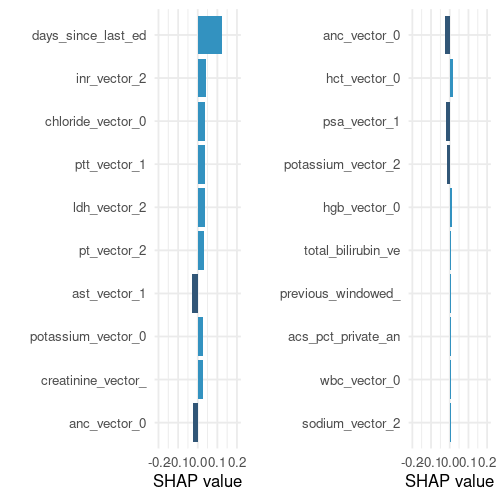

In [0]:
%r
high_p <- plot_indv(high_pred_id, merge_df)
low_p <- plot_indv(low_pred_id, merge_df)
indv_shap_p <- plot_grid(high_p, low_p)

options(repr.plot.width=800, repr.plot.height=300)
indv_shap_p

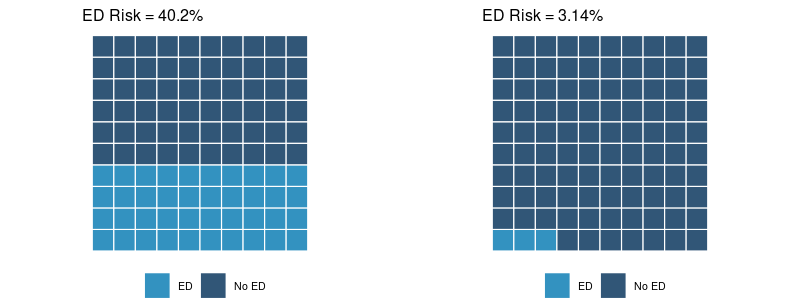

In [0]:
%r
# make high and low risk pictograph
plot_waffle <- function(df) {
  
  waffle_df <- data.frame(
    parts=c("ED", "No ED"),
    vals=c(
      sum(df[["30_days_label"]]==1),
      sum(df[["30_days_label"]]==0)))
  
  ed_risk <- mean(df[["30_days_label"]])
  
  p <- ggplot(waffle_df, aes(fill=parts, values=vals)) + 
    geom_waffle(color="white", size=0.33, flip=TRUE, make_proportional=TRUE) + 
    scale_fill_manual(name="", values=ronin_colors[c(2,1)]) +
    coord_equal() +
    theme_void() +
    ggtitle(paste0("ED Risk = ", format(ed_risk*100, digits=3), "%")) +
    theme(legend.position="bottom",
          text=element_text(size=8))
  
  return(p)
}

high_waffle_p <- plot_waffle(high_df)
low_waffle_p <- plot_waffle(low_df)
waffle_p <- plot_grid(high_waffle_p, low_waffle_p)

options(repr.plot.width=400, repr.plot.height=400)
waffle_p

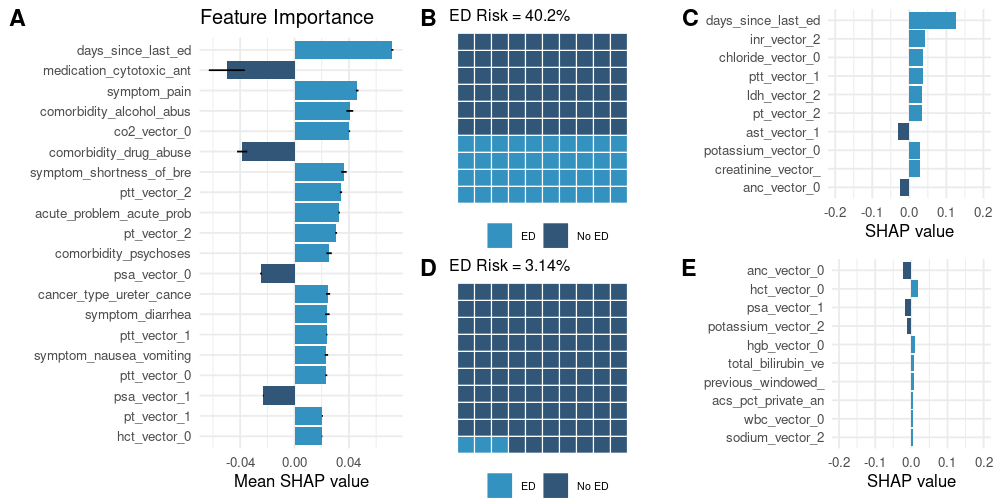

In [0]:
%r
#combined plot version 2
options(repr.plot.width=1000, repr.plot.height=500)

left_col <- plot_grid(shap_p, labels=c("A"))
high_row <- plot_grid(high_waffle_p, high_p, nrow=1, rel_widths=c(0.2, 0.25), labels=c("B", "C"))
low_row <- plot_grid(low_waffle_p, low_p, nrow=1, rel_widths=c(0.2, 0.25), labels=c("D", "E"))
right_col <- plot_grid(high_row, low_row, nrow=2)
combined_plot_2 <- plot_grid(left_col, right_col, ncol=2, rel_widths=c(0.35, 0.5))

combined_plot_2